In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
from tqdm.notebook import tqdm

import numpy as np
import os
import copy
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.cluster import KMeans

# for unzipping
import zipfile

# this makes pyplot in interactive mode
plt.ion()

In [ ]:
!mkdir -p /content/cityscape
%cd /content/cityscape
!gdown https://drive.google.com/uc?id=1-wW9hhaCCjONO_1HZSFR0gpnozYmmDFw

/content/cityscape
Downloading...
From (original): https://drive.google.com/uc?id=1-wW9hhaCCjONO_1HZSFR0gpnozYmmDFw
From (redirected): https://drive.google.com/uc?id=1-wW9hhaCCjONO_1HZSFR0gpnozYmmDFw&confirm=t&uuid=cafe1813-df59-4c06-8e0e-912b4bb2f1a0
To: /content/cityscape/archive.zip
100% 211M/211M [00:05<00:00, 40.2MB/s]


In [ ]:
!unzip archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: cityscapes_data/cityscapes_data/train/2754.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2755.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2756.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2757.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2758.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2759.jpg  
  inflating: cityscapes_data/cityscapes_data/train/276.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2760.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2761.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2762.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2763.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2764.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2765.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2766.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2767.jpg  
  inflating: citysca

In [ ]:

%cd /content

/content


In [ ]:
# train directory
train_dir = '/content/cityscape/cityscapes_data/train'

# validation directory
val_dir = '/content/cityscape/cityscapes_data/val'

print(f'Train directory {train_dir}\nValidation directory {val_dir}\n')

# train, validation samples list
train_samples, validation_samples = os.listdir(train_dir), os.listdir(val_dir)
print(f'Total Training image pairs {len(train_samples)}\nTotal Validation image pairs {len(validation_samples)}\n')

print(f'Sample image shape {np.array(Image.open(os.path.join(train_dir, train_samples[0]))).shape}')

Train directory /content/cityscape/cityscapes_data/train
Validation directory /content/cityscape/cityscapes_data/val

Total Training image pairs 2975
Total Validation image pairs 500

Sample image shape (256, 512, 3)


In [ ]:
# split function
def split_image(image):
  image = np.array(image)
  cityscape, label = image[:,:256,:], image[:,256:,]
  return cityscape, label

cityscape, label = split_image(Image.open(os.path.join(train_dir, train_samples[0])))


In [ ]:
num_classes = 10
num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
# label model using KMeans
label_model = KMeans(n_clusters= num_classes, n_init=10)
label_model.fit(color_array)

KMeans(n_clusters=10, n_init=10)

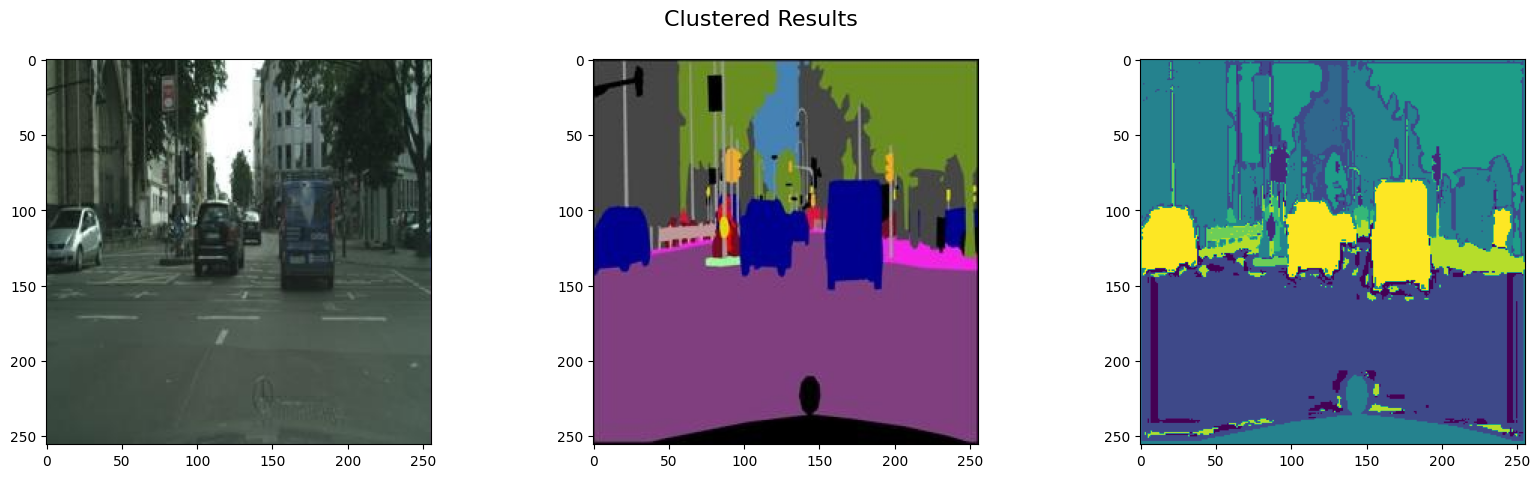

In [ ]:
cityscape, label = split_image(Image.open(os.path.join(train_dir, train_samples[2])))
label_class = label_model.predict(label.reshape(-1,3)).reshape(256,256)

# axes is the object for fig list, instead of fig.add_subplot(1,2,img_count)
# we use axes[0], axes[1] here to access imshow
fig, axes = plt.subplots(1,3,figsize = (20,5))
fig.suptitle('Clustered Results', fontsize = (16))

# Image.fromarray(img) converts the numpy array to PIL Image format "<class 'PIL.Image.Image'>""
axes[0].imshow(Image.fromarray(cityscape))
axes[1].imshow(Image.fromarray(label))
axes[2].imshow(label_class)

plt.show()

In [ ]:
class CityscapeDataset(Dataset):

  def __init__(self, image_dir, label_model):
    self.image_dir = image_dir
    self.image_fns = os.listdir(image_dir)
    self.label_model = label_model

  # double underscore on both side helps it to be callable with the len function of Dataset abstract class
  def __len__(self):
    return len(self.image_fns)

  def __getitem__(self, index):
    image_fn = self.image_fns[index]
    image_fp = os.path.join(self.image_dir, image_fn)
    image = Image.open(image_fp).convert('RGB')
    image = np.array(image)
    cityscape, label = self.split_image(image)
    label_class = self.label_model.predict(label.reshape(-1,3)).reshape(256,256)
    cityscape = self.transform(cityscape)
    label_class = torch.Tensor(label_class).long()
    return cityscape, label_class

  def split_image(self, image):
    image = np.array(image)
    cityscape, label = image[:,:256,:], image[:,256:,]
    return cityscape, label

  def transform(self, image):
    transform_ops = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(mean = (0.485, 0.456, 0.406),
                                                             std = (0.229,0.224,0.225))])
    return transform_ops(image)


In [ ]:
dataset = CityscapeDataset(train_dir, label_model)
print(f'Length of the dataset {len(dataset)}')

# sample representation of dataset
cityscape, label_class = dataset[0]
print(f'Shape of input and output label {cityscape.shape, label_class.shape}')

Length of the dataset 2975
Shape of input and output label (torch.Size([3, 256, 256]), torch.Size([256, 256]))


In [ ]:
device = torch.device('cuda')

In [ ]:
# Batch size of the training
batch_size = 16

data_loader = DataLoader(dataset, batch_size = batch_size)
print(f'Length of dataloader {len(data_loader)}')

data_iter = iter(data_loader)
x, y = next(data_iter)
x, y = x.to(device), y.to(device)
print(f'Input, Label shape of the dataloader {x.shape, y.shape}')

Length of dataloader 186
Input, Label shape of the dataloader (torch.Size([16, 3, 256, 256]), torch.Size([16, 256, 256]))


In [ ]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(SEBlock, self).__init__()
        self.global_pool = nn.AdaptiveAvgPool2d(1)  # Squeeze
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction_ratio, kernel_size=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(in_channels // reduction_ratio, in_channels, kernel_size=1, bias=False)
        self.sigmoid = nn.Sigmoid()  # Excitation

    def forward(self, x):
        # Squeeze
        squeeze = self.global_pool(x)

        # Excitation
        excitation = self.fc1(squeeze)
        excitation = self.relu(excitation)
        excitation = self.fc2(excitation)
        excitation = self.sigmoid(excitation)

        # Apply the learned scaling to the input
        return x * excitation


In [ ]:
class ResidualBlockWithSE(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, reduction_ratio=16):
        super(ResidualBlockWithSE, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.se_block = SEBlock(out_channels, reduction_ratio)

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        # Apply squeeze-and-excitation
        out = self.se_block(out)

        out += identity
        out = F.relu(out)
        return out


In [ ]:
class ResNet26_SE(nn.Module):
    def __init__(self, num_classes=19):
        super(ResNet26_SE, self).__init__()
        self.in_channels = 64

        # Encoder: Initial convolution and residual blocks
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual blocks (Encoder) with SE
        self.layer1 = self._make_layer(64, 3)  # 3 blocks
        self.layer2 = self._make_layer(128, 4, stride=2)  # 4 blocks
        self.layer3 = self._make_layer(256, 6, stride=2)  # 6 blocks
        self.layer4 = self._make_layer(512, 3, stride=2)  # 3 blocks

        # Decoder: Upsampling layers
        self.upconv4 = self._upsample_block(512, 256)
        self.upconv3 = self._upsample_block(256, 128)
        self.upconv2 = self._upsample_block(128, 64)
        self.upconv1 = self._upsample_block(64, 64)

        # Final segmentation head
        self.seg_head = nn.Conv2d(64, num_classes, kernel_size=1)

    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = [ResidualBlockWithSE(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlockWithSE(out_channels, out_channels))

        return nn.Sequential(*layers)

    def _upsample_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        x1 = self.relu(self.bn1(self.conv1(x)))  # First convolution
        x1 = self.maxpool(x1)

        x2 = self.layer1(x1)
        x3 = self.layer2(x2)
        x4 = self.layer3(x3)
        x5 = self.layer4(x4)

        # Decoder
        d4 = self.upconv4(x5) + x4
        d3 = self.upconv3(d4) + x3
        d2 = self.upconv2(d3) + x2
        d1 = self.upconv1(d2)

        # Segmentation head
        out = self.seg_head(d1)

        # Resize output to match input resolution
        out = F.interpolate(out, size=x.size()[2:], mode='bilinear', align_corners=False)
        return out


In [ ]:
from torch.optim.lr_scheduler import StepLR

num_epochs = 25
device = 'cuda'
lr = 1e-03

criterion = nn.CrossEntropyLoss()

model = ResNet26_SE(num_classes=10).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)


In [ ]:
def compute_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            _, predicted = torch.max(outputs, 1)
            total += y.numel()  # Count all pixels
            correct += (predicted == y).sum().item()
    return correct / total


In [ ]:
torch.autograd.set_detect_anomaly(True)
train_loss_history = []
val_loss_history = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (cityscapes, labels) in enumerate(tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        # Move data to device
        cityscapes, labels = cityscapes.to(device), labels.to(device)

        # Forward pass
        outputs = model(cityscapes)
        outputs = outputs.permute(0, 2, 3, 1).reshape(-1, num_classes)  # Adjust shape for CrossEntropyLoss
        labels = labels.view(-1)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

    # Compute average training loss
    avg_train_loss = running_loss / len(data_loader)
    train_loss_history.append(avg_train_loss)

    # Evaluate on validation set (if available)
    if val_dir:
        val_dataset = CityscapeDataset(val_dir, label_model)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for cityscapes, labels in val_loader:
                cityscapes, labels = cityscapes.to(device), labels.to(device)
                outputs = model(cityscapes)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        val_loss_history.append(avg_val_loss)

        # Print training and validation loss
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Compute validation accuracy
        val_accuracy = compute_accuracy(val_loader, model)
        print(f"Validation Accuracy: {val_accuracy:.4%}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

    scheduler.step()

    # Log the current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch [{epoch+1}/{num_epochs}], Current LR: {current_lr:.6f}")




Epoch 1/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [1/25], Train Loss: 1.0034, Val Loss: 0.8139
Validation Accuracy: 73.3538%
Epoch [1/25], Current LR: 0.001000


Epoch 2/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [2/25], Train Loss: 0.7004, Val Loss: 0.7163
Validation Accuracy: 76.7499%
Epoch [2/25], Current LR: 0.001000


Epoch 3/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [3/25], Train Loss: 0.6255, Val Loss: 0.6710
Validation Accuracy: 77.6399%
Epoch [3/25], Current LR: 0.001000


Epoch 4/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [4/25], Train Loss: 0.5855, Val Loss: 0.6813
Validation Accuracy: 77.0360%
Epoch [4/25], Current LR: 0.001000


Epoch 5/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [5/25], Train Loss: 0.5598, Val Loss: 0.7932
Validation Accuracy: 74.7331%
Epoch [5/25], Current LR: 0.001000


Epoch 6/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [6/25], Train Loss: 0.5377, Val Loss: 0.6551
Validation Accuracy: 78.4529%
Epoch [6/25], Current LR: 0.001000


Epoch 7/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [7/25], Train Loss: 0.5212, Val Loss: 0.6241
Validation Accuracy: 79.9248%
Epoch [7/25], Current LR: 0.001000


Epoch 8/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [8/25], Train Loss: 0.5027, Val Loss: 0.6622
Validation Accuracy: 78.8562%
Epoch [8/25], Current LR: 0.001000


Epoch 9/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [9/25], Train Loss: 0.4814, Val Loss: 0.6710
Validation Accuracy: 78.1006%
Epoch [9/25], Current LR: 0.001000


Epoch 10/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [10/25], Train Loss: 0.4788, Val Loss: 0.6630
Validation Accuracy: 78.0246%
Epoch [10/25], Current LR: 0.000100


Epoch 11/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [11/25], Train Loss: 0.4376, Val Loss: 0.5435
Validation Accuracy: 82.3784%
Epoch [11/25], Current LR: 0.000100


Epoch 12/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [12/25], Train Loss: 0.4202, Val Loss: 0.5437
Validation Accuracy: 82.4382%
Epoch [12/25], Current LR: 0.000100


Epoch 13/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [13/25], Train Loss: 0.4118, Val Loss: 0.5432
Validation Accuracy: 82.5056%
Epoch [13/25], Current LR: 0.000100


Epoch 14/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [14/25], Train Loss: 0.4045, Val Loss: 0.5445
Validation Accuracy: 82.5555%
Epoch [14/25], Current LR: 0.000100


Epoch 15/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [15/25], Train Loss: 0.3979, Val Loss: 0.5461
Validation Accuracy: 82.5943%
Epoch [15/25], Current LR: 0.000100


Epoch 16/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [16/25], Train Loss: 0.3914, Val Loss: 0.5485
Validation Accuracy: 82.5980%
Epoch [16/25], Current LR: 0.000100


Epoch 17/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [17/25], Train Loss: 0.3850, Val Loss: 0.5514
Validation Accuracy: 82.5961%
Epoch [17/25], Current LR: 0.000100


Epoch 18/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [18/25], Train Loss: 0.3787, Val Loss: 0.5533
Validation Accuracy: 82.6063%
Epoch [18/25], Current LR: 0.000100


Epoch 19/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [19/25], Train Loss: 0.3726, Val Loss: 0.5552
Validation Accuracy: 82.6299%
Epoch [19/25], Current LR: 0.000100


Epoch 20/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [20/25], Train Loss: 0.3666, Val Loss: 0.5571
Validation Accuracy: 82.6382%
Epoch [20/25], Current LR: 0.000010


Epoch 21/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [21/25], Train Loss: 0.3600, Val Loss: 0.5528
Validation Accuracy: 82.7309%
Epoch [21/25], Current LR: 0.000010


Epoch 22/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [22/25], Train Loss: 0.3584, Val Loss: 0.5534
Validation Accuracy: 82.7314%
Epoch [22/25], Current LR: 0.000010


Epoch 23/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [23/25], Train Loss: 0.3575, Val Loss: 0.5540
Validation Accuracy: 82.7311%
Epoch [23/25], Current LR: 0.000010


Epoch 24/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [24/25], Train Loss: 0.3568, Val Loss: 0.5544
Validation Accuracy: 82.7312%
Epoch [24/25], Current LR: 0.000010


Epoch 25/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [25/25], Train Loss: 0.3560, Val Loss: 0.5549
Validation Accuracy: 82.7298%
Epoch [25/25], Current LR: 0.000010


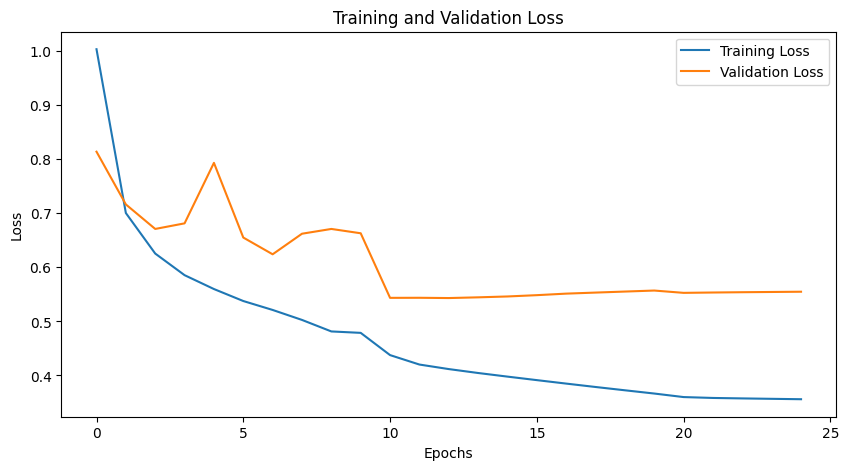

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label="Training Loss")
if val_dir:
    plt.plot(val_loss_history, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
class IoU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoU, self).__init__()

    def forward(self, logits, true, eps=1e-7):

        num_classes = logits.shape[1]
        if num_classes == 1:
            true_1_hot = torch.eye(num_classes + 1, device=true.device)[true.squeeze(1)]
            true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
            true_1_hot_f = true_1_hot[:, 0:1, :, :]
            true_1_hot_s = true_1_hot[:, 1:2, :, :]
            true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
            pos_prob = torch.sigmoid(logits)
            neg_prob = 1 - pos_prob
            probas = torch.cat([pos_prob, neg_prob], dim=1)
        else:
            true_1_hot = torch.eye(num_classes, device=true.device)[true.squeeze(1)]
            true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
            probas = F.softmax(logits, dim=1)
        true_1_hot = true_1_hot.type(logits.type())
        dims = (0,) + tuple(range(2, true.ndimension()))
        intersection = torch.sum(probas * true_1_hot, dims)
        cardinality = torch.sum(probas + true_1_hot, dims)
        union = cardinality - intersection
        iou = (intersection / (union + eps)).mean()
        return iou


iou_metrics = IoU()

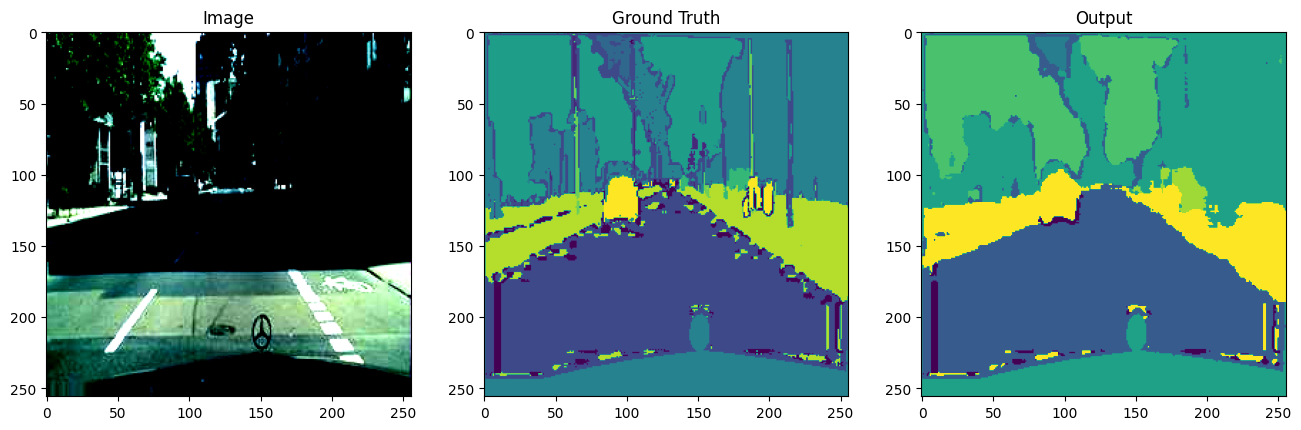

Test IoU = 0.4455290734767914


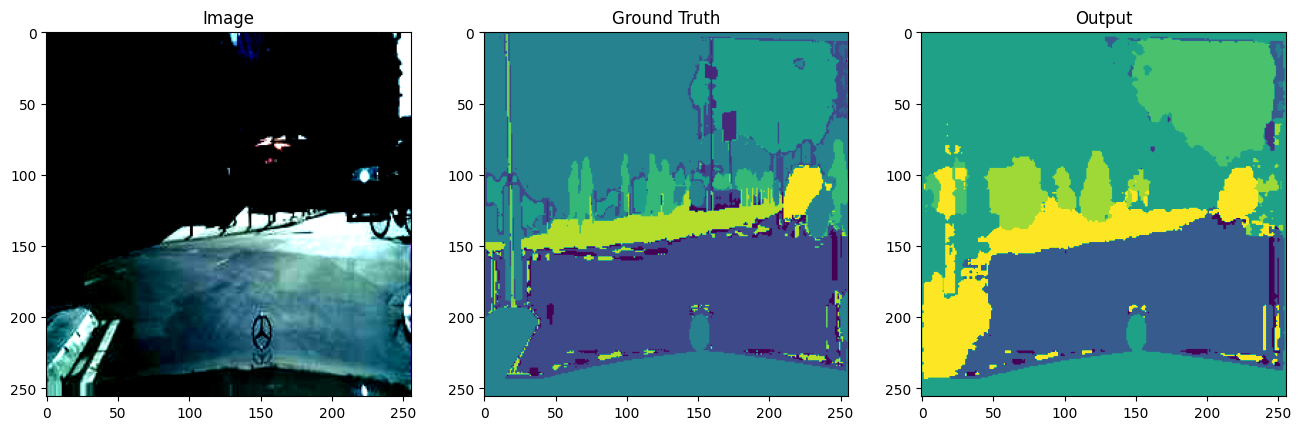

Test IoU = 0.42165738344192505


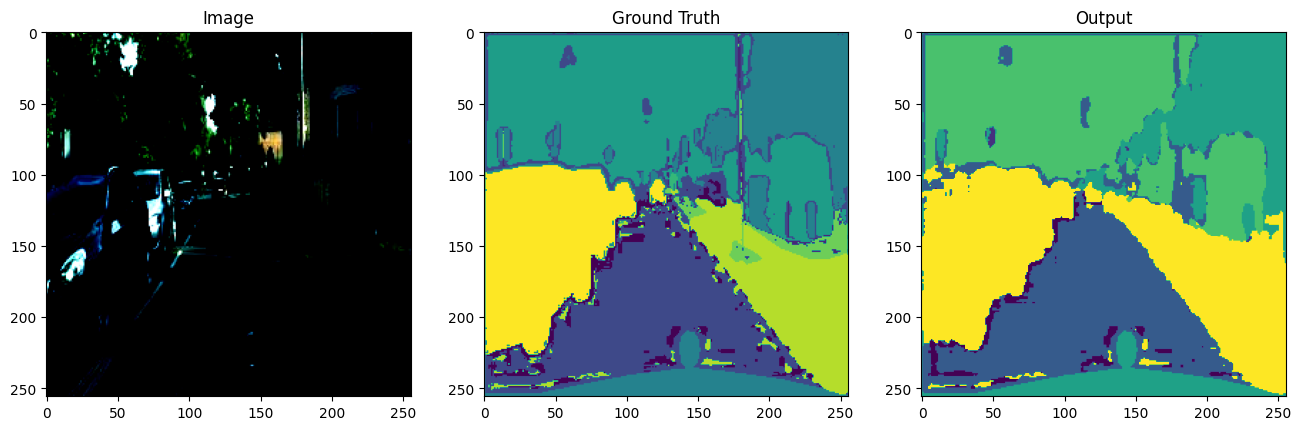

Test IoU = 0.4391678273677826


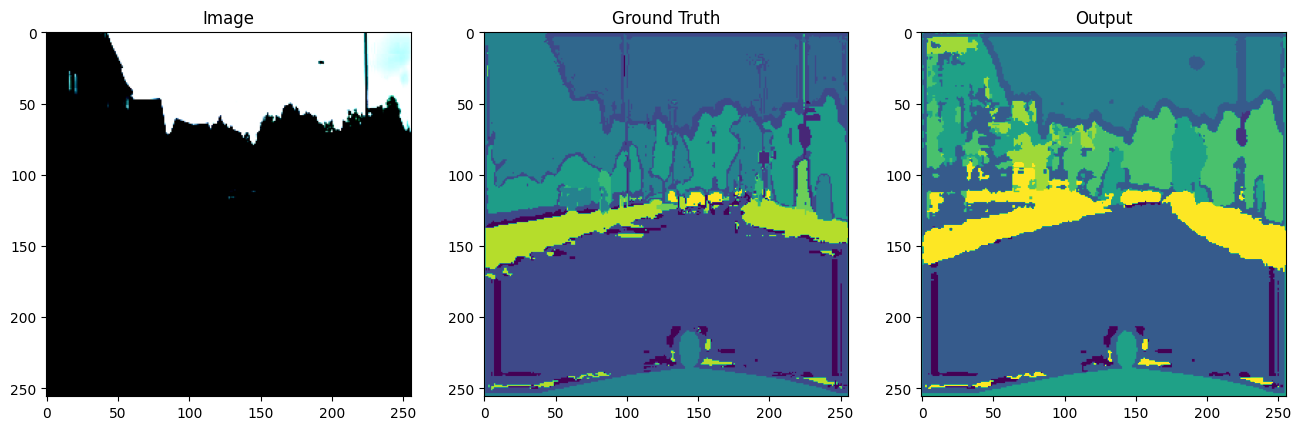

Test IoU = 0.3971434533596039


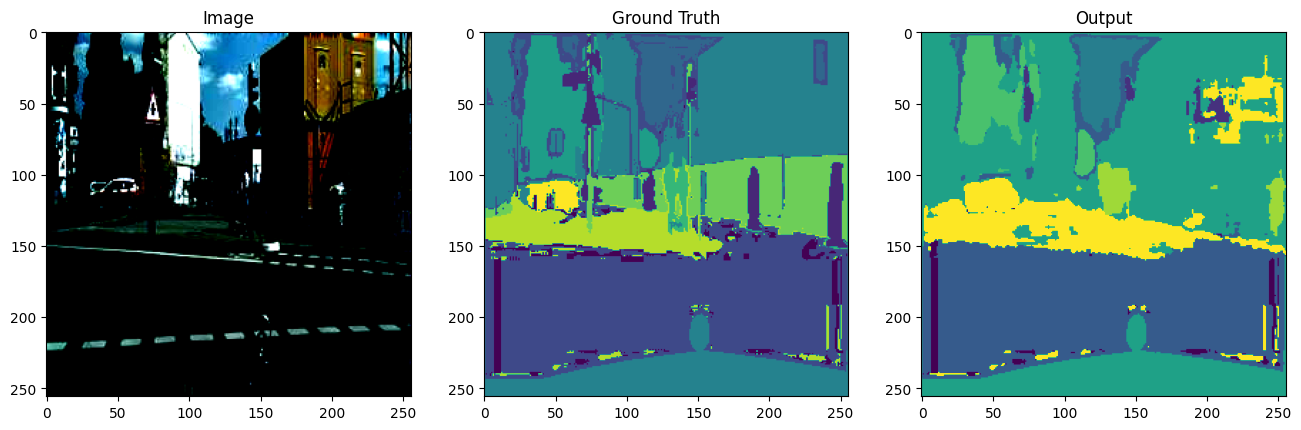

Test IoU = 0.4444045126438141


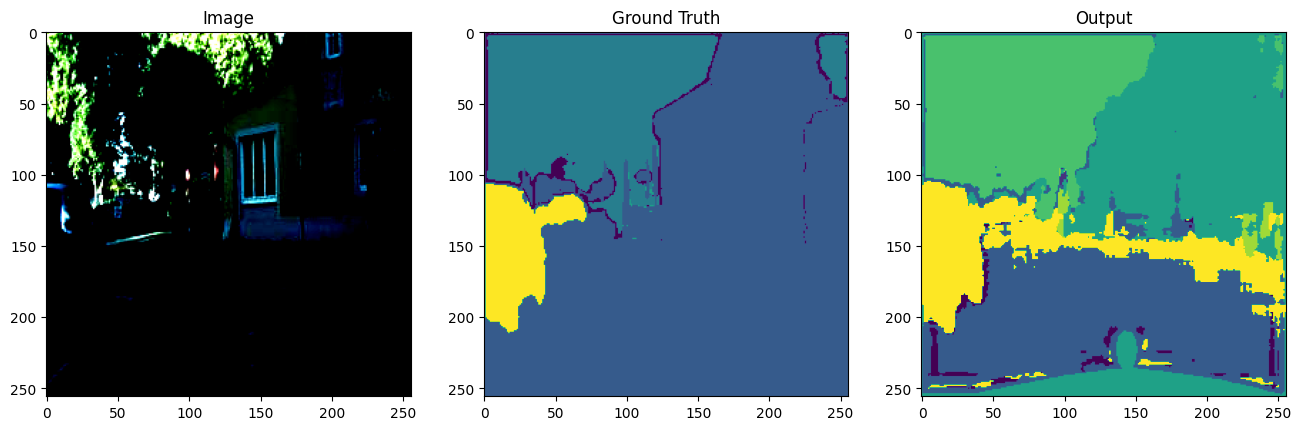

Test IoU = 0.3882344961166382


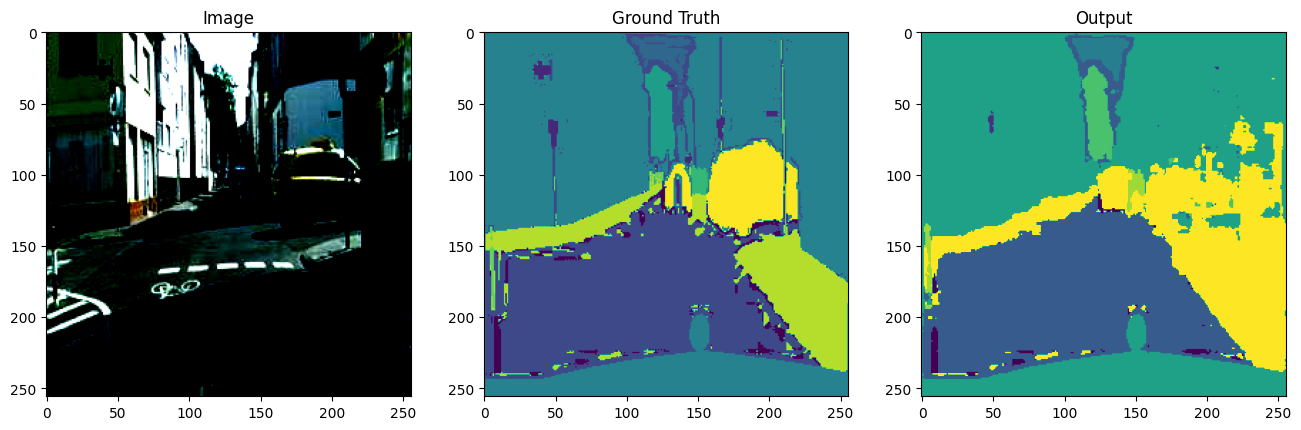

Test IoU = 0.44339391589164734


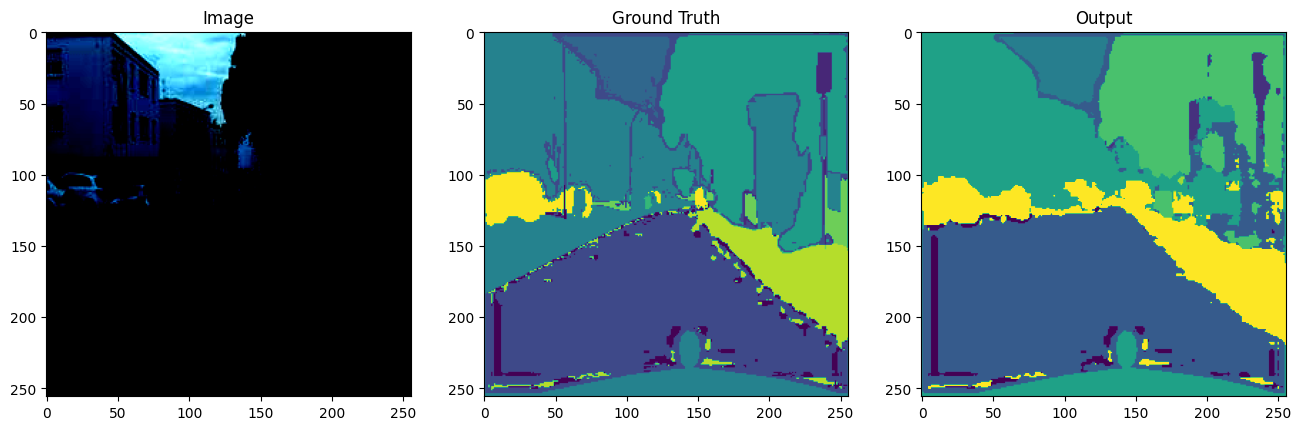

Test IoU = 0.44066810607910156


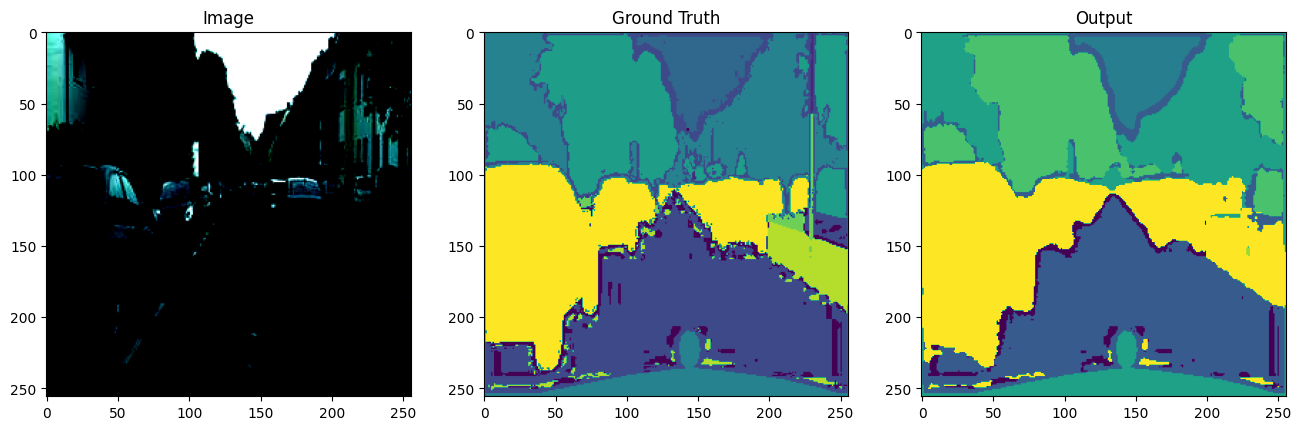

Test IoU = 0.43423518538475037


In [ ]:
test_iou_score = 0.0

with torch.no_grad():
    for i, data in enumerate(val_loader):

        image_tiles, mask_tiles = data

        image = image_tiles.to(device)
        mask = mask_tiles.to(device)

        output = model(image)

        # IoU evaluation
        test_iou = iou_metrics(output, mask)
        test_iou_score += test_iou.item()


        im = image[0].cpu().numpy()
        im = np.moveaxis(im, 0, -1)
        ma = mask[0].cpu().numpy()
        #ma = np.argmax(ma, axis=0)

        out = output[0].cpu().numpy()
        out = np.argmax(out, axis=0)
        plt.figure(figsize=(16,9))
        plt.subplot(131)
        plt.title("Image")
        plt.imshow(im)
        plt.subplot(132)
        plt.title("Ground Truth")
        plt.imshow(ma)
        plt.subplot(133)
        plt.title("Output")
        plt.imshow(out, clim=[0, 7])
        plt.show()

        print(f"Test IoU = {test_iou}")


mean_test_iou_score = test_iou_score / len(val_loader)
print(f"Mean Test IoU = {mean_test_iou_score}")

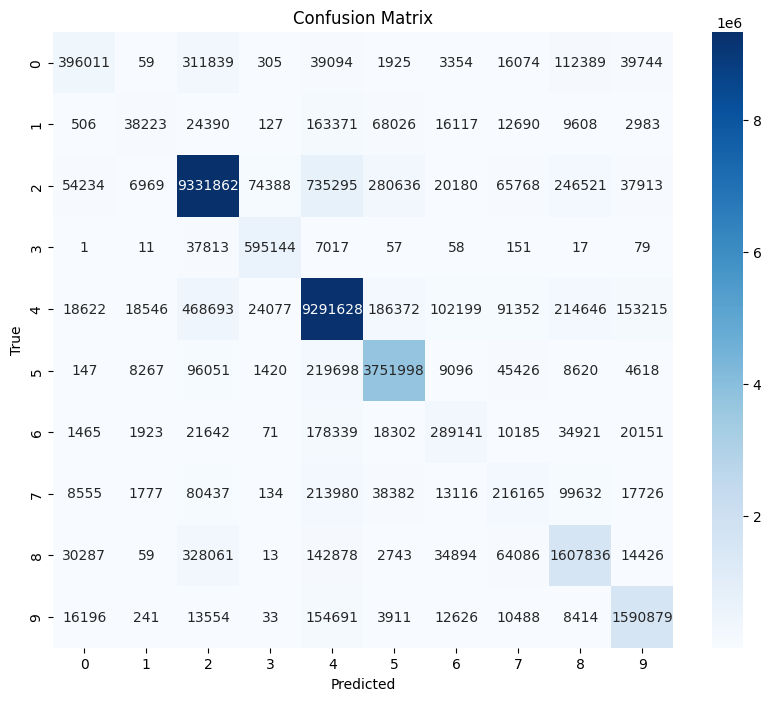

In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, class_names):
    cm = cm.astype('int')
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()



num_classes = 10
class_names = [str(i) for i in range(num_classes)]
conf_matrix = np.zeros((num_classes, num_classes))

with torch.no_grad():
    for i, data in enumerate(val_loader):

        image_tiles, mask_tiles = data

        image = image_tiles.to(device)
        mask = mask_tiles.to(device)

        output = model(image)


        preds = torch.argmax(output, 1).cpu().numpy().flatten()
        targets = mask.cpu().numpy().flatten()
        conf_matrix += confusion_matrix(targets, preds, labels=list(range(num_classes)))

        im = image[0].cpu().numpy()
        im = np.moveaxis(im, 0, -1)
        ma = mask[0].cpu().numpy()
        # ma = np.argmax(ma, axis=0)

        out = output[0].cpu().numpy()
        out = np.argmax(out, axis=0)

plot_confusion_matrix(conf_matrix, class_names)

In [23]:
model_name = 'Resnet26_SE.pth'
torch.save(model.state_dict(), model_name)

In [24]:
import torch.nn.utils.prune as prune
import torch.quantization as quant
from torch.profiler import profile, record_function, ProfilerActivity
import time

def profile_model(model, data_loader, num_batches=10):
    model.eval()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    with profile(
        activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
        on_trace_ready=torch.profiler.tensorboard_trace_handler('./logs'),
        record_shapes=True,
        with_stack=True
    ) as prof:
        for batch_idx, (inputs, targets) in enumerate(data_loader):
            if batch_idx >= num_batches:
                break
            inputs, targets = inputs.to(device), targets.to(device)

            start_time = time.time()
            with record_function("model_inference"):
                outputs = model(inputs)
            latency = time.time() - start_time

    print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))
    print(f"\nLatency per batch: {latency:.4f} seconds")
    print(f"Throughput: {len(inputs) / latency:.4f} samples/second")
    print(f"Peak GPU memory usage: {torch.cuda.max_memory_allocated(device) / (1024 * 1024):.2f} MB")
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Model parameter count: {total_params}")
    print(f"FLOPs estimation: {total_params * 2:.2e} FLOPs")

profile_model(model, data_loader)

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         0.00%       0.000us         0.00%       0.000us       0.000us        1.688s       319.81%        1.688s     168.823ms            10  
                                        model_inference         3.54%      99.542ms        59.87%        1.684s     168.409ms       0.000us         0.00%     487.024ms      48.702ms            10  
         